In [1]:
import os
import pandas as pd
import numpy as np
import json
import re
import tqdm
from collections import Counter
import random

from konlpy.tag import Mecab

# 워드클라우드 형태로 각 레이블 별 중점 단어 시각화
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('raw.csv')

In [3]:
# kdc_label 리스트 화 및 중복 제거 과정
label = df.kdc_label.values

label_list = []
for i in label:
    label_list.append(i)

label_list = list(set(label_list))

In [4]:
len(label_list)

99

In [9]:
print(label_list)

['식품의약안전', '경제학', '국정홍보', '농업·농촌', '경찰', '외교', '사회복지일반', '일반연속간행물', '금융', '한국어', '유아및초·중등교육', '기타', '주택', '체육', '문학', '사회학,사회문제', '산업진흥·고도화', '회화,도화', '총류일반', '고용노동', '상하수도·수질', '물류등기타', '자연', '역사', '과학기술진흥', '윤리학', '기획재정', '보훈', '항공·공항', '도서관학 및 정보과학', '산업·중소기업일반', '지리', '안전관리', '신문, 잡지', '교육학', '통계학', '해양환경', '문헌정보학', '보육·가족및여성', '에너지및자원개발', '영미문학', '형이상학', '국방,군사학', '국정운영', '보건의료', '문화재', '행정학', '노인·청소년', '사회과학', '일반학회, 단체, 협회, 기관', '임업·산촌', '원자력기술', '해운·항만', '교육일반', '국가통계', '정치학', '국민권익·인권', '문화체육관광일반', '세제', '관광', '지역및도시', '심리학', '해양수산·어촌', '한국문학', '오락,스포츠', '연극', '방송통신', '환경일반', '법무및검찰', '법학', '음악', '공학, 공업일반', '무역및투자유치', '기초생활보장', '예술', '대기', '철학', '문화예술', '고등교육', '통상', '철도', '일반행정', '공정거래', '산업금융', '건축술', '풍속,예절,민속학', '도로', '공연예술 및 매체예술', '독일어', '법제', '건강보험', '아시아', '공적연금', '과학기술연구', '취약계층지원', '병무행정', '평생·직업교육', '지방행정·재정지원', '통일']


총 108개의 레이블이 있고, 각각에 대한 단어를 판별하려면 어떻게 해야될까...
진짜 단순하게는, 108개의 key값으로 만드는 각각의 value를 생성한 후, 이를 활용해 명사 추출..?

In [5]:
# 각 레이블 별로 passage 데이터 모으기
passage_by_label = {}

for label in label_list:
    passage_by_label[label] = []
    for i in range(len(df)):
        if label == df['kdc_label'][i]:
            passage_by_label[label].append(df['passage'][i])

In [41]:
total_nouns_by_label = {}

for label in tqdm.tqdm(label_list):
    total_nouns_by_label[label] = []
    temp = []
    for i in range(len(df)):
        if label == df['kdc_label'][i]:
            nouns = text_preprocessing(df['passage'][i])
            temp += nouns
    temp = list(set(temp))
    total_nouns_by_label[label] += temp

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [02:03<00:00,  1.24s/it]


In [48]:
temp = []
for i in total_nouns_by_label['일반행정']:
    if len(i) == 2:
        temp.append(i)
        
print(temp)
#print(total_nouns_by_label['국정홍보'])

['상흔', '민중', '견고', '특화', '미술', '개선', '추급', '종교', '만기', '유적', '문대', '왕실', '눈총', '판별', '감기', '메뉴', '전랑', '당내', '자동', '구이', '몰두', '반문', '서원', '비료', '강정', '술계', '마음', '압박', '절토', '의의', '평일', '항의', '심어', '교량', '러일', '건물', '진화', '평온', '설립', '효력', '호세', '태생', '촉발', '모자', '준용', '정소', '망은', '퀴니', '가점', '한파', '체제', '진일', '뇌물', '도하', '회의', '부착', '신뢰', '생명', '골재', '판결', '지율', '견지', '확인', '육질', '협과', '영입', '감사', '규합', '시도', '금속', '매립', '약점', '일원', '바흐', '지불', '문서', '용암', '밴드', '기욤', '환류', '장강', '태연', '경호', '장단', '구청', '이견', '감분', '법치', '설조', '초유', '관사', '측위', '정철', '급약', '진입', '연못', '내자', '작음', '덕목', '내감', '일용', '사인', '야기', '이식', '암수', '합부', '별일', '신탁', '샛별', '벽면', '불능', '종시', '손질', '동북', '도랑', '고소', '차고', '국정', '정년', '이북', '격식', '충실', '민초', '알약', '설강', '확립', '칼슘', '해염', '어학', '남남', '춘추', '인류', '제반', '임원', '정차', '학군', '원초', '연보', '질환', '원료', '작정', '허점', '타성', '교정', '골간', '변비', '이조', '진척', '울산', '결핵', '호국', '막하', '헬러', '동체', '적폐', '풍요', '상한', '대일', '증가', '명저', '종자', '공안', '사각', '레짐', '반영', '신입', '당수

# Konlpy - Mecab

In [6]:
mecab = Mecab(dicpath = r"C:/mecab/mecab-ko-dic")

In [40]:
def text_preprocessing(text):
    stop_words = ['에서','우리','그것','이것','때문','마찬가지','한때','이후','이전','지금','각종','한편','대부분',
                  '경우','반면','어젠','해당','현재','무엇','예로','군데','여기','만큼','동안','여도','덕분','최근', '이상', '처음', '최소',
                 # 여기서 부터는 공통 명사
                  '사회', '필요', '지원', '관련', '정책', '정부', '결과', '연구', '분석', '국가', '문제',
                  '이번', '북한', '기술', '기업', '정보',
                  '동시', '미만', '이외', '직접', '다운', '로수', '다소간', '이내', '약간', '위해', '당시', '다수', '아무것', '까지', '내주', '미만', '본사', '그간', '지난해', '가운데',
                  '지난날', '지난번', '지난주', '여덟째', '지난달', '나머지', '온종일', '당사자', '내년도', '일순간', '오늘날', '상반기', '오늘', '어제', '그해', '그중', '얼마', '다시',
                  '혼자', '까지', '이때', '차기', '년차', '그때', '다수', '안팎', '오래', '보름', '다년', '이날', '계속', '나중', '동시', '분명', '조금', '과다', '종일', '모두', '다음', '당시', '제때',
                  '일쑤', '실시간', '무조건', '금년도', '최소한', '최대한', '내년도', '유사시', '단기간',
                  '원년', '나마', '등에', '하다', '매해', '초기', '기존', '로서', '다면', '한쪽', '부문', '다중', '요즘', '일시', '후일', '내년', '오전', '오후', '돌연', '보통', '예외', '밤새', '금번',
                  '시일', '그날', '금년', '만일', '에도', '건너', '결국', '그만큼', '가급적', '스스로', '대다수', '이즈음', '동일시', '갖가지', '제각각', '안일한', '현시점', '한마디', '무엇인가',
                  '제법', '잠깐', '일종', '오직', '다소', '즉시', '연일', '마다', '한데', '항상', '자칭', '대신', '이래', '이하', '이상', '라고', '한낮', '일단'
                  
                 ]

    text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]", " ", text)  # 한글 및 공백을 제외한 문자 제거(영문자, 특수문자)
    temp = []
    pos_data = mecab.pos(text)
    
    for i in pos_data:
        if (i[1] == 'NNG' or i[1] == 'NNP') and len(i[0]) > 1:
            temp.append(i[0])
        else : continue
    
    #nouns = mecab.nouns(text)  # 명사 추출
    nouns = [token for token in temp if not token in stop_words]  # 명사 중 불용어에 해당되면 삭제
    
    return list(nouns)

In [8]:
nouns_by_label = {}

for label in tqdm.tqdm(label_list):
    nouns_by_label[label] = []
    for i in range(len(df)):
        if label == df['kdc_label'][i]:
            nouns = text_preprocessing(df['passage'][i])
            nouns_by_label[label].append(nouns) 

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [01:58<00:00,  1.19s/it]


In [14]:
Font_Path = r"C:\Windows\Fonts\malgun.ttf"

In [15]:
nouns_by_label['연극']

text = ''

for i in range(len(nouns_by_label['연극'])):
    for j in nouns_by_label['연극'][i]:
        text = text + ' ' + j

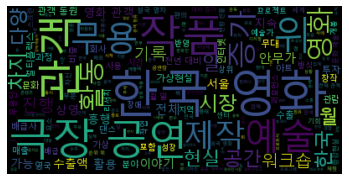

In [16]:
# 해양 수산 어촌
wordcloud = WordCloud(max_font_size=60, relative_scaling=.5, font_path=Font_Path).generate(text) # generate() 는 하나의 string value를 입력 받음
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [17]:
# 비지도 학습 기반 단어 벡터화 : Cohesion score

In [18]:
# 단어 빈도수 파악 -> 공통적으로 등장하는 단어 제외하기 위함

In [19]:
# 각 라벨의 명사 전체 모음
for i in range(len(label_list)):
    globals()['nouns_{}'.format(i)] = []
    for j in nouns_by_label[label_list[i]]:
        globals()['nouns_{}'.format(i)] += j
    

In [20]:
def get_tags(nouns, ntags):
    count = Counter(nouns)
    x = []
    y = []  # 명사 빈도수 저장할 변수
    for n, c in count.most_common(ntags):
        x.append(n) # word(tag)
        y.append(c)
    
    return x, y

In [105]:
# 가급적 비교용으로 사용
for i in range(len(label_list)):
    n, c = get_tags(globals()['nouns_{}'.format(i)], n_tags)
    print('{} -> {} : {}\n'.format(label_list[i], n, c))

금융 -> ['금융', '시장', '투자', '경제', '위기', '기후', '부채', '주택', '소비자', '가계', '기간', '경력', '증가', '기대', '조정', '가능', '수준', '사업', '부문', '확대', '월', '효과', '평가', '대출', '민간'] : [385, 297, 249, 231, 210, 204, 193, 171, 166, 166, 153, 153, 139, 134, 133, 131, 131, 126, 125, 122, 120, 115, 114, 114, 113]

상하수도·수질 -> ['처리', '시설', '지하수', '하수', '관리', '물', '지역', '계획', '수질', '이용', '사업', '운영', '영향', '평가', '환경', '공공', '유입', '개발', '기준', '재정', '변화', '발생', '효율', '개선', '오염'] : [413, 355, 281, 271, 257, 219, 177, 170, 162, 161, 156, 154, 138, 136, 126, 124, 122, 112, 110, 98, 93, 89, 88, 88, 84]

해양환경 -> ['관측', '기상', '해양', '자료', '피해', '예보', '안개', '태풍', '사용', '서비스', '분야', '적용', '연안', '발생', '해상', '지역', '영향', '제공', '모델', '선박', '예측', '값', '월', '활용', '알고리즘'] : [41, 35, 32, 32, 21, 21, 18, 18, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 14, 13, 13, 13, 13, 12, 12]

무역및투자유치 -> ['중국', '경제', '미국', '지역', '한국', '시장', '투자', '사업', '협력', '개발', '국제', '가능', '전략', '산업', '생산', '증가', '무역', '발전', '관계', '점', '변화', '세계', '추진', '동북', '상황'] : [3

In [104]:
data_dictionary = {}
n_tags = 25
for i in range(len(label_list)):
    n, c = get_tags(globals()['nouns_{}'.format(i)], n_tags)
    #print('{} -> {} : {}\n'.format(label_list[i], n, c))
    data_dictionary[label_list[i]] = n

In [57]:
data_dictionary

{'금융': ['금융', '시장', '투자', '경제', '위기', '기후', '부채', '주택', '소비자', '가계'],
 '상하수도·수질': ['처리', '시설', '지하수', '하수', '관리', '물', '지역', '계획', '수질', '이용'],
 '해양환경': ['관측', '기상', '해양', '자료', '피해', '예보', '안개', '태풍', '사용', '서비스'],
 '무역및투자유치': ['중국', '경제', '미국', '지역', '한국', '시장', '투자', '사업', '협력', '개발'],
 '법제': ['문서', '전자', '규정', '법', '조제', '청구인', '기관', '지방', '처분', '사업'],
 '오락, 운동': ['올림픽', '체력', '조사', '평화', '평창', '국민', '남북', '근력', '위험', '한국'],
 '항공·공항': ['항공', '공항', '시장', '산업', '계획', '적용', '사업', '운송', '경쟁', '수립'],
 '정치학': ['통일', '중국', '경제', '남북', '정치', '평화', '월', '미국', '협력', '관계'],
 '관광': ['관광', '지역', '산업', '관광객', '사업', '문화', '개발', '여행', '경제', '추진'],
 '임업·산촌': ['산림', '지역', '환경', '환경영향평가', '사업', '제도', '이용', '펠릿', '생산', '계획'],
 '고등교육': ['대학', '교육', '학생', '과정', '평가', '졸업', '학교', '컨설팅', '학습', '운영'],
 '지역및도시': ['지역', '도시', '사업', '계획', '개발', '활용', '조사', '문화', '주민', '마을'],
 '신문, 잡지': ['생명', '자살', '사람', '마음', '하나님', '인간', '자신', '행위', '정신', '한울님'],
 '안전관리': ['안전', '위험', '재난', '관리', '사고', '교육', '계획', '행동', '발생

In [106]:
# 랜덤한 인덱스로 500개의 테스트
doc_name_list = []

random_idx = []
random_num = random.randint(0,3998)

for i in range(500):
    while random_num in random_idx:
        random_num = random.randint(0,3998)
    random_idx.append(random_num)

doc_content = {}

for i in random_idx:
    doc_content[doc_name_list[i]] = []
    for j in range(len(df)):
        if doc_name_list[i] == df.doc_name.values[j]:
            doc_content[doc_name_list[i]].append(df.passage.values[j])
        
    doc_content[doc_name_list[i]] = " ".join(doc_content[doc_name_list[i]])

In [107]:
test_key = list(doc_content.keys())
test_item = list(doc_content.values())

In [108]:
check_list = []
for i in test_key:
    check_list.append(df.loc[df['doc_name'] == i]['kdc_label'].values[0])
len(check_list)

100

In [109]:
answer_list = []
for i in test_item:
    test_noun = text_preprocessing(i)

    score_label = []
    score_board = [i for i in range(n_tags,0,-1)] # 위의 ntag에 맞춰서 해결

    for i in data_dictionary:
        score = 0
        for j in range(0,n_tags):   
            for k in test_noun:
                if k == data_dictionary[i][j]:
                    score += score_board[j]
        score_label.append(score)
        
    answer_list.append(list(data_dictionary.keys())[score_label.index(max(score_label))])

In [110]:
check = 0
for i in range(len(check_list)):
    '''
    check = False
    if check_list[i] == answer_list[i]:
        check = True
    print("답 : {} \t 예측 : {} \t {}".format(check_list[i],answer_list[i],check))
    '''  
    if check_list[i] == answer_list[i]:
        check += 1
print(check/len(check_list) * 100)

39.0


In [71]:
print(score_label)

[806, 264, 45, 2889, 144, 152, 236, 2307, 1710, 662, 296, 2216, 224, 243, 3099, 336, 66, 626, 490, 1038, 2555, 755, 153, 250, 1694, 526, 148, 591, 383, 148, 58, 41, 205, 337, 204, 483, 984, 1112, 144, 602, 2970, 29, 757, 430, 74, 290, 1403, 458, 218, 326, 506, 471, 141, 727, 221, 761, 677, 230, 14, 572, 507, 31, 245, 708, 918, 6500, 1423, 97, 105, 1285, 356, 245, 929, 307, 260, 158, 549, 77, 79, 3771, 5100, 258, 180, 951, 174, 422, 331, 86, 1648, 121, 276, 4720, 78, 363, 52, 350, 245, 778, 1149, 101, 857, 76, 91, 7635, 312, 738, 351, 955]


In [74]:
list(data_dictionary.keys())[score_label.index(max(score_label))]

'병무행정'

In [45]:
key = list(data_dictionary.keys())
print(key)

['풍속,예절,민속학', '문화체육관광일반', '사회학,사회문제', '노인·청소년', '보육·가족및여성', '일반학회, 단체, 연구조사기관', '통계학', '항공·공항', '회화,도화', '과학기술연구', '주택', '안전관리', '국방, 군사학', '통일', '심리학', '공학, 공업일반', '철학', '보훈', '건축술', '총류일반', '음악', '행정학', '한국어', '관광', '통상', '평생·직업교육', '방송통신', '과학기술진흥', '지방행정·재정지원', '재정·금융', '문학', '공적연금', '산업·중소기업일반', '환경일반', '형이상학', '교육학', '정치학', '지리', '문화예술', '예술', '경제학', '고등교육', '경찰', '체육', '아시아', '해양수산·어촌', '농업·농촌', '오락,스포츠', '윤리학, 도덕철학', '기획재정', '오락, 운동', '상하수도·수질', '공정거래', '물류등기타', '국정홍보', '건강보험', '해양환경', '일반학회, 단체, 협회, 기관', '원자력기술', '무역및투자유치', '일반연속간행물', '신문, 잡지', '아시아(아세아)', '기타', '산업진흥·고도화', '산업금융', '식품의약안전', '교육일반', '금융', '병무행정', '사회학, 사회문제', '보건의료', '일반행정', '외교', '해운·항만', '풍속, 민속학', '윤리학', '법학', '기초생활보장', '지역및도시', '임업·산촌', '자연', '독일어', '영미문학', '역사', '유아및초·중등교육', '법제', '사회복지일반', '고용노동', '문화재', '국정운영', '한국문학', '공연예술 및 매체예술', '일반학회, 단체,협회,기관', '도로', '법무및검찰', '국방,군사학', '도서관학 및 정보과학', '사회과학', '철도', '에너지및자원개발', '연극', '문헌정보학', '국가통계', '취약계층지원', '대기', '세제', '국민권익·인권']


In [60]:
list(doc_content.values())

['한국을 중심으로 중국, 일본 등 동양에서는 옻칠의 이러한 특성을 이용하여 선사시대부터 식기 및 생활도구나 무기류, 농기구 등을 제작할 경우 가공하여 사용하는 과정에서 갈라지고 터지는 등의 결함을 보완할 수 있는 재료로 옻칠을 사용하였다. 나무로 만든 생활도구나 식기 등에 옻칠을 하면 표면이 견고하고 단단한 막을 형성할 뿐만 아니라 광택이 나고 오랫동안 사용하여도 변하지 않아 목기류의 보존 및 내구성이 우수한 천연도료로 인정받게 되었다. 이러한 특성 때문에 동양에서는 4,000년 전부터 칠기문화가 발전하게 되었고 단순한 생활용품 이외에도 각종 예술품, 귀금속이나 목공도장용, 칠기류 등에 널리 쓰이게 되었다. 황칠의 주요 구성 성분은 크게 나누어 황금색의 도막을 형성하는 도료성분인 비휘발성분과 방향성성분이 약 77%를 차지하고 그 나머지는 수분과 고형분으로 되어 있다. 또한 황칠의 주요 구성 성분으로는 α-Cubebene, β-Elemene, β-Gurjunene,Germacrene D, Elixene, β-Cubebene, β-Selinene, γ-Selinene, α-Muurolene, γ-Cadinene, δ-Cadinene, Juniper camphor 등과 같은 sesquiterpenoid 화합물과 steroid인 β-sitosterol 등으로 구성되어 있으며, 세스퀴테르펜류의 β-Cubebene(30.1%), γ-Selinene(,16.1%), δ-Cadinene(13.5%) 이 주성분을 이루고 있었다. 황칠나무는 우리나라 온대남부 및 난대에 속하는 남․서 해안 도서지역과 제주도에 주로 분포하고 있는데 지리적으로 가장 동쪽의 분포지역은 경남 거제도의 갈곶도이고 서쪽은 전남 신안군 소흑산도, 남쪽은 제주도, 북쪽은 충남 보령군의 외연도이다. 그리고 내륙지역의 분포 북한계는 전남 해남 두륜산이다. 그러나 이들 천연 분포지역을 벗어난 광주광역시, 충남 서산(천리포 수목원), 전북 전주, 전남 순천, 함평, 경북 울진 등의 지역에서도 식재목으로서 양호한 생